<a href="https://colab.research.google.com/github/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/blob/main/proyecto_churninsight_prediccion_de_cancelacion_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto ChurnInsight: Predicción de Cancelación de Clientes**

aca ira la descripción del proyecto y la problematica

##**Extracción**

###**Importando las librerias y cargando el data set desde GitHub**

In [1]:
#importando las librerias
import pandas as pd
import io
import requests

In [2]:
#cargando las bases de datos
import pandas as pd
import io
import requests

# FUNCIÓN MAESTRA DE CARGA
def cargar_desde_github(url_raw, nombre_archivo="dataset"):
    """
    Lee un CSV desde GitHub Raw forzando UTF-8 y manejando errores comunes.
    """
    try:
        print(f"📡 Conectando a {nombre_archivo}...")

        # 1. Hacemos la petición web (Request)
        response = requests.get(url_raw)
        response.raise_for_status() # Lanza error si el link está roto (404)

        # 2. Decodificamos el contenido forzando UTF-8
        # Esto asegura que tildes, ñ y caracteres especiales se lean bien en cualquier navegador
        contenido_texto = response.content.decode('utf-8')

        # 3. Convertimos el texto en un DataFrame
        df = pd.read_csv(io.StringIO(contenido_texto), sep=',')

        print(f"✅ {nombre_archivo} cargado exitosamente: {df.shape[0]} filas, {df.shape[1]} columnas.")
        return df

    except requests.exceptions.HTTPError as err:
        print(f"❌ Error: El enlace está roto o es privado. Verifica la URL Raw.\nDetalle: {err}")
    except pd.errors.ParserError:
        print(f"❌ Error: El archivo no parece ser un CSV válido o el separador no es coma.")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")
        return None

# --- TUS URLS RAW (Reemplaza estas líneas con TUS links reales) ---
# Ejemplo: 'https://raw.githubusercontent.com/TU_USUARIO/TU_REPO/main/base_clientes_real.csv'

url_clientes = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_clientes_real.csv"
url_logs     = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_logs_real.csv"
url_finanzas = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_facturacion_real.csv"

# --- EJECUCIÓN DE LA CARGA ---
# Solo ejecutará si has puesto los links, si no, te avisará.
if "PEGAR_AQUI" not in url_clientes:
    df_clientes = cargar_desde_github(url_clientes, "Tabla Clientes")
    df_logs = cargar_desde_github(url_logs, "Tabla Logs")
    df_facturacion = cargar_desde_github(url_finanzas, "Tabla Facturación")
else:
    print("⚠️ ¡Atención! Debes pegar tus links RAW de GitHub en las variables de arriba para continuar.")

📡 Conectando a Tabla Clientes...
✅ Tabla Clientes cargado exitosamente: 1800 filas, 4 columnas.
📡 Conectando a Tabla Logs...
✅ Tabla Logs cargado exitosamente: 1800 filas, 3 columnas.
📡 Conectando a Tabla Facturación...
✅ Tabla Facturación cargado exitosamente: 1800 filas, 4 columnas.


**Notas:**<br>
¿Por qué este esquema es mejor que un simple pd.read_csv()?
<br>
**requests.get(url).content.decode('utf-8'):** Esta es la clave. A veces GitHub sirve los archivos con encabezados extraños. Al descargar el contenido y decodificarlo explícitamente antes de pasarlo a Pandas, garantizas que Windows, Mac y Linux lean los caracteres igual.

**io.StringIO:** Convierte ese texto en un "archivo virtual" en memoria, lo que es mucho más rápido y seguro que guardar temporales en el disco.

**sep=',':** Aunque es el defecto, es mejor ser explícito por si subes un CSV separado por punto y coma (común en Excel en español).

###**Uniendo las tablas de datos**

Vamos a usar el customer_id como la llave para conectar las tablas. Usaremos un inner join, lo que significa que solo nos quedaremos con los clientes que existan en las tres tablas (para asegurar que tenemos datos completos de todos).



In [3]:
#Código de Merge (Unificación)

# Paso A: Unir Clientes + Logs
# Usamos 'how=inner' para asegurar intersección exacta
df_temp = pd.merge(df_clientes, df_logs, on='customer_id', how='inner')
print(f"   -> Unión 1 (Clientes + Logs): {df_temp.shape[0]} filas")

# Paso B: Unir el resultado anterior + Finanzas
df_master = pd.merge(df_temp, df_facturacion, on='customer_id', how='inner')
print(f"   -> Unión 2 (+ Finanzas): {df_master.shape[0]} filas")

# --- VALIDACIÓN DE INTEGRIDAD ---
# Es vital verificar que no se hayan disparado las filas (duplicados)
# ni que tengamos columnas con nombres raros (ej: tenure_x, tenure_y)

print("\n2. Dataset Maestro Generado:")
print(f"   Dimensiones finales: {df_master.shape}")
print(f"   Columnas: {df_master.columns.tolist()}")

# --- VISTA PREVIA DEL PROBLEMA ---
# Miremos las primeras filas para confirmar que la unión trajo la 'suciedad'
# que debemos limpiar en el siguiente paso.
print("\n3. Muestra de datos (Observa 'tenure' y 'total_spend'):")
print(df_master[['customer_id', 'tenure', 'total_spend', 'churn']].head(5))

   -> Unión 1 (Clientes + Logs): 1800 filas
   -> Unión 2 (+ Finanzas): 1800 filas

2. Dataset Maestro Generado:
   Dimensiones finales: (1800, 9)
   Columnas: ['customer_id', 'tenure', 'contract_type', 'subscription_type', 'usage_time', 'login_frequency', 'payment_record', 'total_spend', 'churn']

3. Muestra de datos (Observa 'tenure' y 'total_spend'):
  customer_id  tenure         total_spend  churn
0   REAL-1438   113.0               62.97      0
1   REAL-3674    67.0  45.510000000000005      0
2   REAL-2345    98.0               21.09      1
3   REAL-2957   147.0               60.56      0
4   REAL-3148    96.0               53.83      0


##**Conociendo el conjunto de datos**

###**Explorando las columnas del dataset y verificando sus tipos de datos.**

In [4]:
df_master.head()

,customer_id,tenure,contract_type,subscription_type,usage_time,login_frequency,payment_record,total_spend,churn
0,REAL-1438,113.0,Month-to-Month,Basic,675.0,93,Good,62.97,0
1,REAL-3674,67.0,Month-to-Month,Basic,514.9,117,Good,45.510000000000005,0
2,REAL-2345,98.0,Month-to-Month,Basic,326.7,0,Delayed,21.09,1
3,REAL-2957,147.0,Month-to-Month,Basic,573.1,79,Good,60.56,0
4,REAL-3148,96.0,Month-to-Month,Basic,596.4,102,Good,53.83,0


In [5]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1800 non-null   object 
 1   tenure             1750 non-null   float64
 2   contract_type      1800 non-null   object 
 3   subscription_type  1800 non-null   object 
 4   usage_time         1800 non-null   float64
 5   login_frequency    1800 non-null   int64  
 6   payment_record     1800 non-null   object 
 7   total_spend        1800 non-null   object 
 8   churn              1800 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 126.7+ KB


##**Diccionario de Datos**

El objetivo de este diccionario es comprender la definición de las columnas y sus valores asociados.
Las columnas seleccionadas son las siguientes:
<br><br>

 - **customer_id:**'
 - **tenure:**
 - **contract_type:**
 - **subscription_type**
 - **usage_time:**
 - **login_frequency:**
 - **payment_record:**
 - **total_spend:**
 - **churn**

##**Transformación**

**Acciones más comunes a realizar**

+ Duplicados
+ Valores Vacíos
+ Valores nulos
+ Tipos de datos
+ Valores atípicos
+ Consistencia y validez de datos categóricos
+ Normalización de textos

###**Verificar si hay valores únicos en cada columna**

In [6]:

for col in df_master.columns:
  print(f"valores únicos en la columna'{col}': {df_master[col].nunique()}")
  if df_master[col].nunique() < 50: #imprima los valores solamente si no hay muchos
    print(df_master[col].unique())
    print('-' * 50) #linea divisoria para mejorar visualización

valores únicos en la columna'customer_id': 1800
valores únicos en la columna'tenure': 200
valores únicos en la columna'contract_type': 2
['Month-to-Month' 'Two Year']
--------------------------------------------------
valores únicos en la columna'subscription_type': 2
['Basic' 'Premium']
--------------------------------------------------
valores únicos en la columna'usage_time': 1470
valores únicos en la columna'login_frequency': 111
valores únicos en la columna'payment_record': 2
['Good' 'Delayed']
--------------------------------------------------
valores únicos en la columna'total_spend': 1569
valores únicos en la columna'churn': 2
[0 1]
--------------------------------------------------


###**Verificar si existen valores duplicados y nulos**

In [7]:
# Verificando si hay duplicados
duplicados = df_master.duplicated().sum()
print(f"Número de duplicados: {duplicados}")

#verificamos si hay valores Nulos
#es .values para que nos entregue un numero y no nos entregue un objeto
valores_nulos = df_master.isnull().values.sum()
print(f"\nValores nulos por comlumna: ")
print(valores_nulos[valores_nulos > 0])

Número de duplicados: 0

Valores nulos por comlumna: 
[50]


In [9]:
print('Valores nulos por columna:')
print(df_master.isnull().sum())

Valores nulos por columna:
customer_id           0
tenure               50
contract_type         0
subscription_type     0
usage_time            0
login_frequency       0
payment_record        0
total_spend           0
churn                 0
dtype: int64


Como podemos ver, la columna `tenure` es la única que presenta valores nulos. Ahora necesitamos decidir cómo manejar estos 50 valores faltantes. Algunas estrategias comunes incluyen:


*   **Imputar valores:** Rellenar los valores nulos con una estadística (media, mediana, moda) o un valor predicho.

In [13]:
# Calcula la mediana de la columna 'tenure'
median_tenure = df_master['tenure'].median()

# Imputa los valores nulos con la mediana de forma segura
df_master['tenure'] = df_master['tenure'].fillna(median_tenure)

# Verifica que ya no hay valores nulos en 'tenure'
print(f"Valores nulos en 'tenure' después de la imputación: {df_master['tenure'].isnull().sum()}")


Valores nulos en 'tenure' después de la imputación: 0


### **Limpieza y Conversión de Tipos de Datos**

In [15]:
# 1. Limpiar y convertir 'total_spend' a tipo float
print("Limpiando y convirtiendo 'total_spend'...")

# Eliminar caracteres no numéricos (como '$' o comas)
df_master['total_spend'] = df_master['total_spend'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# Convertir a tipo numérico (float)
# Usamos errors='coerce' para convertir a NaN cualquier valor que no se pueda transformar a número
df_master['total_spend'] = pd.to_numeric(df_master['total_spend'], errors='coerce')

# Verificar si quedaron nulos después de la conversión (por si hubo valores no convertibles)
print(f"Valores nulos en 'total_spend' después de la conversión: {df_master['total_spend'].isnull().sum()}")

# 2. Verificar el tipo de dato y los primeros valores
print("\nTipo de dato de 'total_spend' después de la conversión:")
print(df_master['total_spend'].dtype)
print("\nPrimeros 5 valores de 'total_spend':")
print(df_master['total_spend'].head())


Limpiando y convirtiendo 'total_spend'...
Valores nulos en 'total_spend' después de la conversión: 0

Tipo de dato de 'total_spend' después de la conversión:
float64

Primeros 5 valores de 'total_spend':
0    62.97
1    45.51
2    21.09
3    60.56
4    53.83
Name: total_spend, dtype: float64


Después de esta operación, la columna `total_spend` estará lista para análisis numéricos. Si hay más columnas que necesiten una transformación similar o si tienes alguna otra columna en mente, házmelo saber.

Con esto, hemos manejado los valores nulos en la columna `tenure`. Ahora todos los 1800 registros tienen un valor para esta característica.

### **Conversión a tipos de datos deseados**

In [ ]:
# 1. Convertir 'churn' a tipo booleano
print("Convirtiendo 'churn' a tipo booleano...")
df_master['churn'] = df_master['churn'].astype(bool)
print(f"Tipo de dato de 'churn' después de la conversión: {df_master['churn'].dtype}")
print("Primeros 5 valores de 'churn' después de la conversión:")
print(df_master['churn'].head())

# 2. Convertir 'payment_record' a 0 y 1
print("\nConvirtiendo 'payment_record' a valores numéricos (0 y 1)...")
mapping_payment = {'Good': 0, 'Delayed': 1}
df_master['payment_record'] = df_master['payment_record'].map(mapping_payment)
print(f"Tipo de dato de 'payment_record' después de la conversión: {df_master['payment_record'].dtype}")
print("Primeros 5 valores de 'payment_record' después de la conversión:")
print(df_master['payment_record'].head())

# Verificar la información general del DataFrame para confirmar los cambios
print("\nInformación del DataFrame después de las conversiones:")
df_master.info()


Con estas transformaciones, las columnas `churn` y `payment_record` estarán en un formato más adecuado para el análisis y el modelado. `churn` como booleano es más claro para representar una decisión binaria, y `payment_record` como 0/1 es un formato numérico que muchos algoritmos de Machine Learning esperan para características categóricas binarias.

In [17]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1800 non-null   object 
 1   tenure             1800 non-null   float64
 2   contract_type      1800 non-null   object 
 3   subscription_type  1800 non-null   object 
 4   usage_time         1800 non-null   float64
 5   login_frequency    1800 non-null   int64  
 6   payment_record     1800 non-null   object 
 7   total_spend        1800 non-null   float64
 8   churn              1800 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 126.7+ KB


Con esto, hemos manejado los valores nulos en la columna `tenure`. Ahora todos los 1800 registros tienen un valor para esta característica.

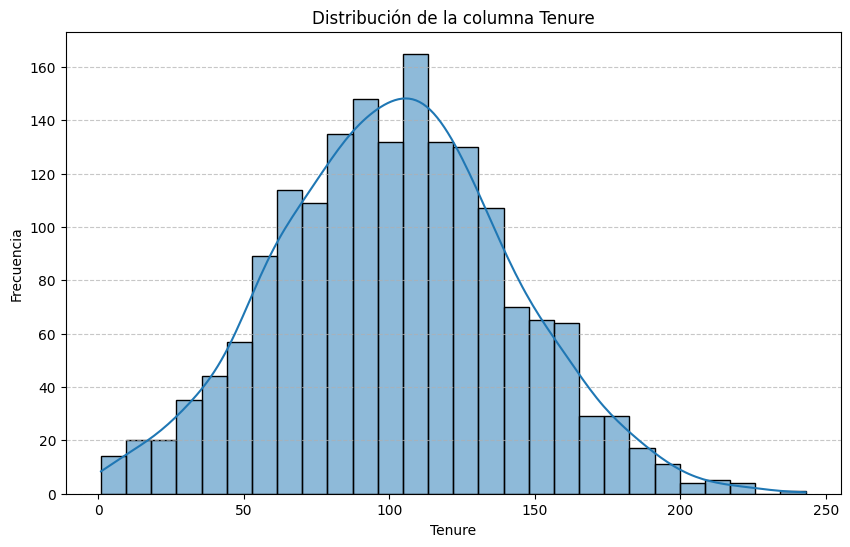

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_master['tenure'].dropna(), kde=True)
plt.title('Distribución de la columna Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Análisis Exploratorio de Datos (EDA)**

### **Estadísticas Descriptivas de Columnas Numéricas**

In [16]:
print('Estadísticas descriptivas para columnas numéricas:')
print(df_master[['tenure', 'usage_time', 'login_frequency', 'total_spend']].describe())


Estadísticas descriptivas para columnas numéricas:
            tenure   usage_time  login_frequency  total_spend
count  1800.000000  1800.000000      1800.000000  1800.000000
mean    101.837778   582.261556       100.326667    56.772711
std      39.604371    89.878787        19.871207    10.487452
min       1.000000   292.600000         0.000000    21.090000
25%      75.000000   519.025000        87.000000    49.545000
50%     102.000000   585.350000       101.000000    56.805000
75%     127.000000   643.400000       114.000000    63.915000
max     243.000000   876.900000       163.000000    89.470000


Este resumen nos dará una idea de la tendencia central, dispersión y forma de la distribución de cada una de estas columnas.

Este histograma te mostrará la forma de la distribución de `tenure`. Si la distribución es asimétrica (tiene una 'cola' más larga a un lado), la mediana será una mejor opción para la imputación que la media, ya que es menos sensible a los valores extremos.